# SELECT * FROM interesting

In [1]:
import json
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.neural_network import MLPClassifier
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

tqdm.pandas()

In [2]:
image_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
image_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

idx_df = pd.read_csv("./../data/index.csv")

def get_vector_from_filename(fn):
    img = Image.open(f"./../data/image-{fn}")
    inputs = image_processor(images=img, return_tensors="pt")
    return image_model.get_image_features(**inputs)[0].tolist()

idx_df['vector'] = idx_df['image_filename'].progress_apply(get_vector_from_filename)

100%|███████████████████████████████████████| 2000/2000 [01:39<00:00, 20.05it/s]


In [73]:
cfx_df = pd.read_json('./../data/human-classifications.json')
training_df = pd.merge(
    idx_df,
    cfx_df[cfx_df['name'] == "contains_human"],
    left_on="id",
    right_on="image_id",
    how="inner"
) \
    [["id", "image_filename", "value", "vector"]] \
    .rename(columns={"value": "contains_human"})

training_df['contains_human'] = training_df['contains_human'].apply(lambda d: 1 if d == True else 0)

In [107]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, image_filename_train, image_filename_test = train_test_split(
    training_df['vector'].tolist(),
    training_df['contains_human'].tolist(),
    training_df['image_filename'].tolist(),
    test_size=0.25,
    random_state=42
)

hidden_layer_sizes = (round(math.sqrt(len(x_train[0]))),)
max_iter = 2000

clf = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=42)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")

Accuracy: 0.9523809523809523
Precision: 0.9523809523809523
Recall: 0.975609756097561


The classifier is 52% sure this does contain a human.


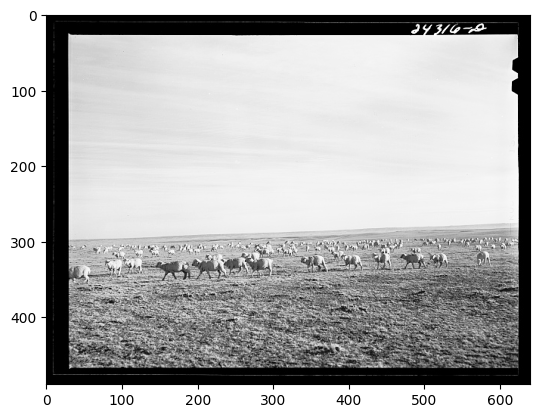

The classifier is 76% sure this does contain a human.


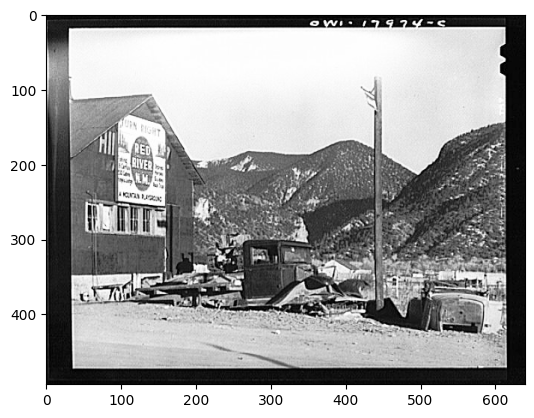

The classifier is 84% sure this does not contain a human.


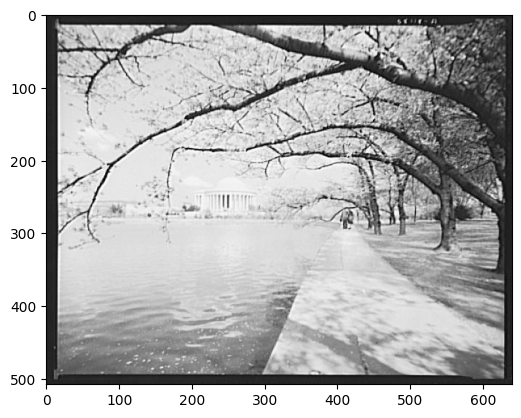

In [126]:
for idx, image_filename in enumerate(image_filename_test):
    if y_pred[idx] != y_test[idx]:
        does = 'does' if y_pred[idx] == 1 else 'does not'
        prop_percent = round(y_prob[idx][y_pred[idx]] * 100)
        print(f"The classifier is {prop_percent}% sure this {does} contain a human.")
        img = Image.open(f"./../data/image-{image_filename}")
        plt.imshow(img, cmap="Greys_r")
        plt.show()

In [133]:
predictions = clf.predict(idx_df['vector'].tolist())
probabilities = clf.predict_proba(idx_df['vector'].tolist())

classifications = []

for idx, row in enumerate(idx_df.to_dict('records')):
    pred = predictions[idx]
    prob = probabilities[idx]
    classifications.append({
        "image_id": row["id"],
        "contains_human": int(pred), # Because it's an Int64 for dumb reasons.
        "probability": float(prob[pred]), # See above.
    })

with open('./../data/machine-classifications.json', 'w') as out_file:
    json.dump(classifications, out_file)

In [139]:
clf_df = pd.read_json('./../data/machine-classifications.json')
df = pd.merge(
    idx_df[["id", "image_url", "date", "title", "creators", "image_filename", "vector"]],
    clf_df.rename(columns={"image_id": "id"}),
    how="inner"
)

In [140]:
out_data = []
for row in df.to_dict('records'):
    out_data.append({
        'id': row['id'],
        "contains_human": row["contains_human"],
        'image_filename': row['image_filename'],
        'vector': row['vector']
    })

with open('./../data/vectors.json', 'w') as out_file:
    json.dump(out_data, out_file)

In [137]:
df.contains_human.value_counts()

contains_human
1    1038
0     962
Name: count, dtype: int64